In [1]:
# ============================================================
# 00_WINDOWING — Segmentacja sygnałów i czystość etykiet (WESAD)
# ============================================================

import pickle
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------------------
# Mapa klas WESAD
# ------------------------------------------------------------
CLASS_MAP = {0: "baseline", 1: "amusement", 2: "stress"}
INV_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

In [3]:
# ------------------------------------------------------------
# Funkcje pomocnicze
# ------------------------------------------------------------
def load_wesad_subject(pkl_path: str):
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    return data

def to_seconds(idx: int, fs: int) -> float:
    return idx / float(fs)

def to_index(t: float, fs: int) -> int:
    return int(round(t * fs))

In [4]:
# ------------------------------------------------------------
# Tworzenie przedziałów klas (spans)
# ------------------------------------------------------------
def label_spans_from_array(y: np.ndarray, fs_label: int) -> Dict[str, List[Tuple[float, float]]]:
    spans = {}
    i = 0
    n = len(y)
    while i < n:
        cls = y[i]
        j = i + 1
        while j < n and y[j] == cls:
            j += 1
        if cls in CLASS_MAP:
            t1, t2 = to_seconds(i, fs_label), to_seconds(j, fs_label)
            spans.setdefault(CLASS_MAP[cls], []).append((t1, t2))
        i = j
    return spans

In [5]:
# ------------------------------------------------------------
# Konfiguracja okien
# ------------------------------------------------------------
@dataclass
class WindowingConfig:
    win_sec: float
    stride_sec: float
    purity: float = 0.90
    fs_signal: int = 700
    fs_label: int = 700

def iter_windows(n_samples: int, cfg: WindowingConfig):
    win = to_index(cfg.win_sec, cfg.fs_signal)
    step = to_index(cfg.stride_sec, cfg.fs_signal)
    for start in range(0, n_samples - win + 1, step):
        yield start, start + win

# ------------------------------------------------------------
# Przypisywanie etykiety do okna
# ------------------------------------------------------------
def assign_label_for_window(t_start: float, t_end: float, spans: Dict[str, List[Tuple[float, float]]], purity: float) -> Optional[str]:
    ts = np.arange(t_start, t_end, 0.1)
    if len(ts) == 0:
        return None
    cover = {c: 0 for c in spans.keys()}
    for c, lst in spans.items():
        for a, b in lst:
            cover[c] += np.sum((ts >= a) & (ts < b))
    total = sum(cover.values())
    if total == 0:
        return None
    cls, cnt = max(cover.items(), key=lambda kv: kv[1])
    if (cnt / total) >= purity:
        return cls
    return None  # odrzuć mieszane okno

In [6]:
# ------------------------------------------------------------
# Budowanie okien i etykiet
# ------------------------------------------------------------
def build_windows_and_labels(signal: np.ndarray, y_label: np.ndarray, cfg: WindowingConfig):
    spans = label_spans_from_array(y_label, cfg.fs_label)
    X_windows, y_windows = [], []
    for start_idx, end_idx in iter_windows(len(signal), cfg):
        t1 = to_seconds(start_idx, cfg.fs_signal)
        t2 = to_seconds(end_idx, cfg.fs_signal)
        lbl = assign_label_for_window(t1, t2, spans, cfg.purity)
        if lbl is None:
            continue
        X_windows.append(signal[start_idx:end_idx])
        y_windows.append(INV_CLASS_MAP[lbl])
    print(f"Utworzono {len(y_windows)} czystych okien (purity≥{cfg.purity*100:.0f}%)")
    return np.array(X_windows, dtype=float), np.array(y_windows, dtype=int)

In [7]:
# ------------------------------------------------------------
# Proste statystyki cech (szybki screening)
# ------------------------------------------------------------
def basic_stats_features(X_windows: np.ndarray) -> np.ndarray:
    feats = []
    for w in X_windows:
        feats.append([
            np.mean(w), np.std(w), np.min(w), np.max(w),
            skew(w, bias=False), kurtosis(w, fisher=True, bias=False)
        ])
    return np.array(feats, dtype=float)

In [8]:
# ------------------------------------------------------------
# Wizualna kontrola etykiet w czasie
# ------------------------------------------------------------
def plot_label_segments(y: np.ndarray, fs: int, title="Label sequence"):
    t = np.arange(len(y)) / fs
    plt.figure(figsize=(12, 2))
    plt.scatter(t, y, s=2, c=y, cmap="coolwarm")
    plt.yticks([0, 1, 2], ["baseline", "amusement", "stress"])
    plt.xlabel("Time [s]")
    plt.ylabel("Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

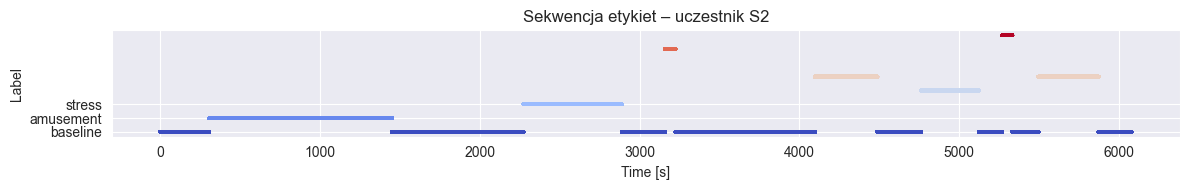

Utworzono 3215 czystych okien (purity≥90%)
Rozkład klas dla okna 3s: {np.int64(0): np.int64(2046), np.int64(1): np.int64(761), np.int64(2): np.int64(408)}
[ 3s] macro-F1=0.755 (n_okien=3215)
Utworzono 1928 czystych okien (purity≥90%)
Rozkład klas dla okna 5s: {np.int64(0): np.int64(1228), np.int64(1): np.int64(456), np.int64(2): np.int64(244)}
[ 5s] macro-F1=0.795 (n_okien=1928)
Utworzono 1378 czystych okien (purity≥90%)
Rozkład klas dla okna 7s: {np.int64(0): np.int64(879), np.int64(1): np.int64(325), np.int64(2): np.int64(174)}
[ 7s] macro-F1=0.822 (n_okien=1378)
Zapisano czyste okna: windows_S2_7s_purity90.npz
Utworzono 965 czystych okien (purity≥90%)
Rozkład klas dla okna 10s: {np.int64(0): np.int64(617), np.int64(1): np.int64(227), np.int64(2): np.int64(121)}
[10s] macro-F1=0.776 (n_okien=965)
Utworzono 806 czystych okien (purity≥90%)
Rozkład klas dla okna 12s: {np.int64(0): np.int64(516), np.int64(1): np.int64(189), np.int64(2): np.int64(101)}
[12s] macro-F1=0.751 (n_okien=806)
U

In [9]:
# ============================================================
# TEST segmentacji i klasyfikacji dla uczestnika S2
# ============================================================

data = load_wesad_subject("/Volumes/blue_nateck/WESAD/S2/S2.pkl")
sig = data['signal']['chest']['ECG'].squeeze()
y = data['label'].astype(int).squeeze()

fs_sig = 700
fs_lab = 700

plot_label_segments(y, fs_lab, title="Sekwencja etykiet – uczestnik S2")

window_grid = [3, 5, 7, 10, 12, 15]
results = []

for win_s in window_grid:
    cfg = WindowingConfig(win_sec=win_s, stride_sec=win_s/2, purity=0.90, fs_signal=fs_sig, fs_label=fs_lab)
    Xw, yw = build_windows_and_labels(sig, y, cfg)

    if len(yw) < 20:
        print(f"[{win_s}s] Za mało czystych okien ({len(yw)}). Pomijam.")
        continue

    # Rozkład klas
    unique, counts = np.unique(yw, return_counts=True)
    print(f"Rozkład klas dla okna {win_s}s:", dict(zip(unique, counts)))

    # Ekstrakcja prostych cech
    X = basic_stats_features(Xw)

    # 70/30 split (na razie po oknach)
    X_tr, X_te, y_tr, y_te = train_test_split(X, yw, test_size=0.3, random_state=42, stratify=yw)

    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)
    y_pr = clf.predict(X_te)
    f1m = f1_score(y_te, y_pr, average='macro')

    results.append((win_s, f1m, len(yw)))
    print(f"[{win_s:>2}s] macro-F1={f1m:.3f} (n_okien={len(yw)})")

    # Zapisz dane z najlepszego okna (np. 7 s)
    if win_s == 7:
        np.savez(f"windows_S2_{win_s}s_purity{int(cfg.purity*100)}.npz", Xw=Xw, yw=yw)
        print(f"Zapisano czyste okna: windows_S2_{win_s}s_purity{int(cfg.purity*100)}.npz")


Tabela wyników (screening długości okna):


,window_s,f1_macro,n_clean_windows
2,7,0.822369,1378
1,5,0.794568,1928
3,10,0.776207,965
0,3,0.755095,3215
5,15,0.753227,645
4,12,0.750969,806


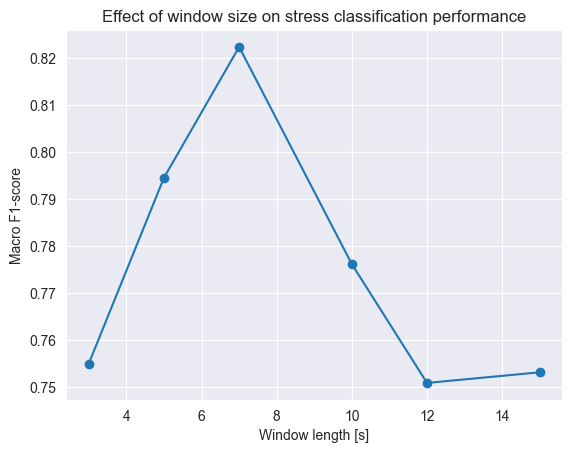

In [10]:
# ============================================================
# Analiza wyników
# ============================================================

results_df = pd.DataFrame(results, columns=["window_s", "f1_macro", "n_clean_windows"])
print("\nTabela wyników (screening długości okna):")
display(results_df.sort_values("f1_macro", ascending=False))

plt.plot(results_df["window_s"], results_df["f1_macro"], marker='o')
plt.xlabel("Window length [s]")
plt.ylabel("Macro F1-score")
plt.title("Effect of window size on stress classification performance")
plt.grid(True)
plt.show()